# Piano Grid Experimentation
I want to do some more testing on the Rousseau videos to find a good way to automatically detect the piano grid.

**Goal**: Given a reference frame for a video, automatically create a grid to detect where the piano keys are in the image. This will be used later to determine which fingers are on top of which keys

**Example** (From the paper *Virtual Piano using Computer Vision*):
![](../visualizations/key-extraction-paper.png)

##### Log
* 03/01/2023: Initial notes
* 03/02/2023: Plot brightness on top of image
* 03/03/2023: Try plotting a bunch of video frames
* 04/24/2023: Discussing
* 05/01/2023: Vertical cropping, how to represent keys

### Finding the keyboard from brightness rows
From experimentation, I found that from the opening scene of a video, the pixel row with the highest average brightness lies on the bed of the piano white keys. I want to see if this is a pattern, and how consistent it is.

I'll also prove this assumtion in the next cells ;)

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
import copy

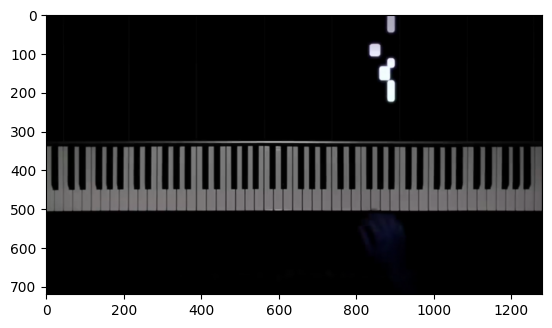

In [2]:
# Extract a good sample frame (this was very specifically picked)
filepath = '../data/full_playlist/trimmed_videos/Carol of the Bells (Christmas Piano Cover).mp4'
second = 1.3

video = cv2.VideoCapture(filepath)
fps = video.get(cv2.CAP_PROP_FPS)
frame_id = int(fps*second)

video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = video.read()

sample_img = frame

plt.imshow(frame)

(720, 1280, 3)


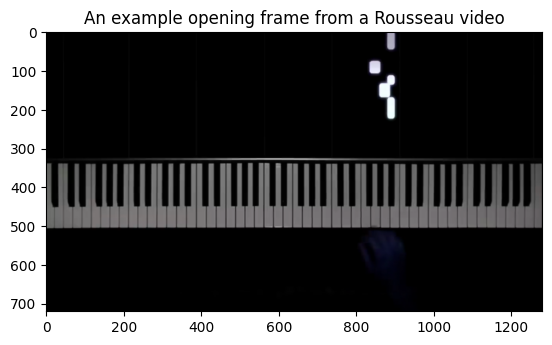

In [3]:
# Example frame
# sample_img = cv2.imread('../piano.png')
print(sample_img.shape)
plt.title('An example opening frame from a Rousseau video')
plt.imshow(sample_img)

Now, I'll try plotting that line I was talking about...

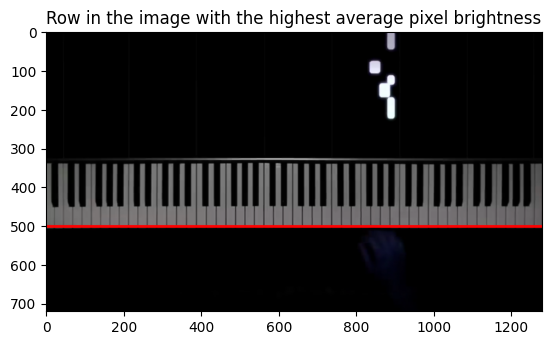

In [4]:
# Plotting the line with the max average brightness
mean_brightness_per_row = [np.mean(sample_img[i, :,:]) for i in range(sample_img.shape[0])]

# Finding the row with the max avg brightness
line_index = mean_brightness_per_row.index(max(mean_brightness_per_row))

# Creating a line with that index
sample_img_with_line = copy.deepcopy(sample_img) # create copy to not plot line on original variable
cv2.line(sample_img_with_line, (0, line_index), (sample_img_with_line.shape[1], line_index), (255, 0, 0), 6)

# Plot
plt.title('Row in the image with the highest average pixel brightness')
plt.imshow(sample_img_with_line)

See what I mean? Here, let me plot a graph of the brightness per row to prove that it's not just luck...

#### Plotting brightness alongside the sample image:

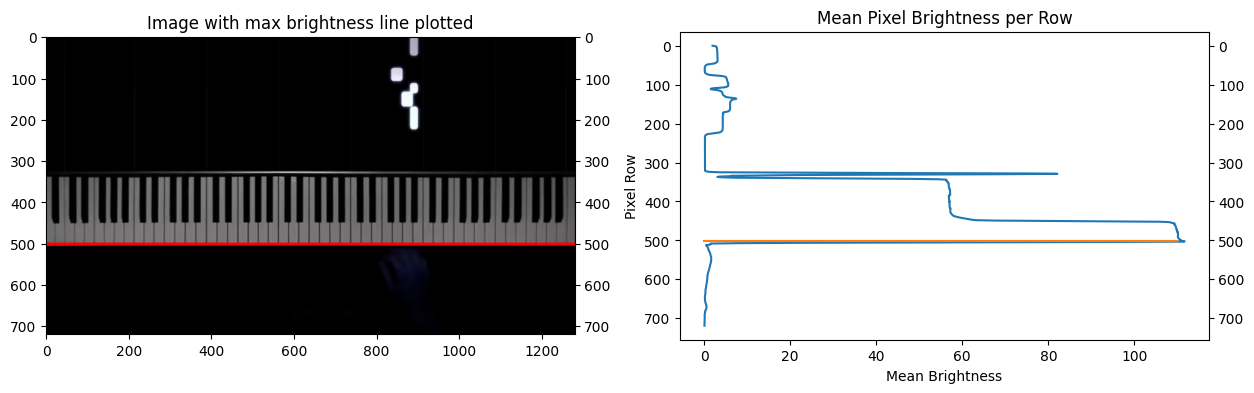

In [5]:
# Using subplots to plot piano keys beside a veritcal graph of pixel brightness
fig, axs = plt.subplots(1, 2, figsize=(15,4))

y = range(sample_img.shape[0])

# Piano image
axs[0].imshow(sample_img_with_line)
axs[0].set(title='Image with max brightness line plotted')
axs[0].tick_params(labelright=True, right=True)

# Brightness plot
axs[1].plot(mean_brightness_per_row, y)
# Plot red line for show max brightness
axs[1].plot([line_index for i in range(int(max(mean_brightness_per_row)))])
axs[1].invert_yaxis()
axs[1].set(title='Mean Pixel Brightness per Row', 
       ylabel='Pixel Row',
       xlabel='Mean Brightness')
axs[1].tick_params(labelright=True, right=True)

plt.show()

This is annoying to manually align my two plots (I experimented with the figsize to align for my window size), may not be scalable when plotting a bunch of these later...

#### Plotting directly on the image:

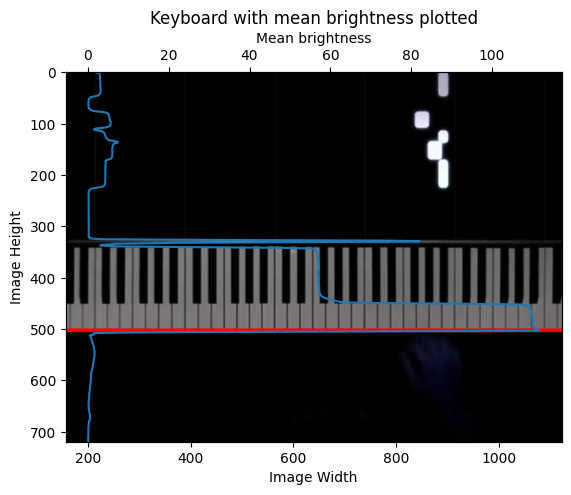

In [6]:
fig, ax = plt.subplots()

y = range(sample_img.shape[0])

# plot them together
ax.imshow(sample_img_with_line)
ax.set(title='Keyboard with mean brightness plotted',
      ylabel='Image Height',
      xlabel='Image Width')

# I want two different x-axis scales, here's my attempt
ax2 = ax.twiny()
ax2.plot(mean_brightness_per_row, y)
ax2.set(xlabel='Mean brightness')


plt.show()

## Plotting brightness on multiple videos
Now that I've got a a good way to graph, let's test this on multiple videos to see if this is a consistent pattern.

### Assumption time!
I watched some videos to see if they all have frames like seen above, where the hands aren't in the way of the video. **From my observation,** the title screen (where the keyboard is NOT visible) takes 4 seconds and the first note is played at around 10 seconds. Therefore, I will take a frame of each video right at **4 seconds**.

In [7]:
def grab_opening_frames(path_to_video_folder='../data/full_playlist/videos', second=4):
    '''
    Returns a list of single frames, one from each video in the folder
    
        Parameters:
            path_to_video_folder (str): relative path to mp4 files
            second (int): index to grab the frame from each video
            
        Returns:
            frames (list): list of numpy arrays representing an image frame
    '''
    frames = []
    
    for filename in os.listdir(path_to_video_folder):
        if filename.endswith('.mp4'):
            filepath = os.path.join(path_to_video_folder, filename)
            video = cv2.VideoCapture(filepath)
            fps = video.get(cv2.CAP_PROP_FPS)
            frame_id = int(fps*second)

            video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
            ret, frame = video.read()
            frames.append(frame)
        
    return frames

In [8]:
opening_frames = grab_opening_frames()
print(f'Number of videos: {len(opening_frames)}')

Number of videos: 143


### Plotting a bunch of opening frames with brightness curves:

In [52]:
def plot_multiple(imgs, rows=5, cols=5, size=(15, 12)):
    'Given a list of images, plots them all side-by-side'
    
    fig, axs = plt.subplots(rows, cols, figsize=size)

    for i in range(rows*cols):
        row = int(i/cols)
        col = i % cols

        if i >= len(imgs):
            print('More plots than images, stopping.')
            break
            
        img = imgs[i]
        axs[row,col].imshow(img)

In [10]:
# Need a special function since some funky axis work is needed 
def plot_multiple_brightness(imgs, rows=5, cols=5, size=(15,12)):
    'Given a list of images, plots them all side-by-side'
    
    fig, axs = plt.subplots(rows, cols, figsize=size)

    for i in range(rows*cols):
        row = int(i/rows)
        col = i % cols

        if i >= len(imgs):
            print('More plots than images, stopping.')
            break
            
        img = copy.deepcopy(imgs[i])

        mean_brightness = [np.mean(img[j, :,:]) for j in range(img.shape[0])]
        y = range(img.shape[0])

        axs[row,col].imshow(img)
        ax2 = axs[row,col].twiny()
        ax2.plot(mean_brightness, y)

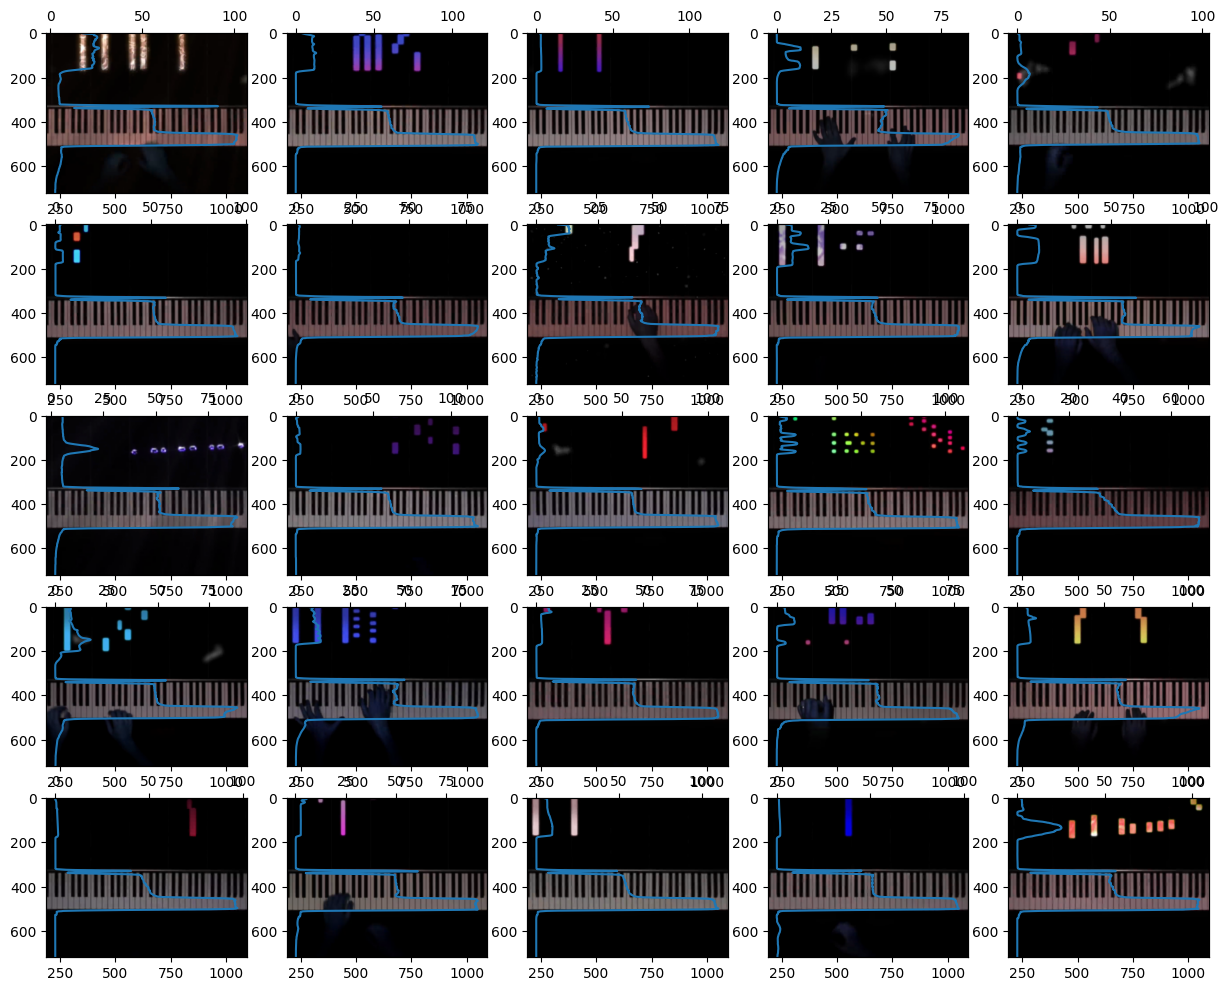

In [11]:
plot_multiple_brightness(opening_frames)

### Conclusion for max brightness
Based on these results, I think it is **safe to confirm my assumption** that we can use the max brightness as a point on the bed of the piano white keys.

We can also use more info from these brightness curves to **crop the video vertically**.

But first, let's use the max brightness to **separate the white piano keys**...

## Separating the white keys

We now know where the white keys are, so we can use the **brightness across that row** to 
distiguish white keys.

Let's take the max brightness row in our sample image, and plot the RGB values across that row...

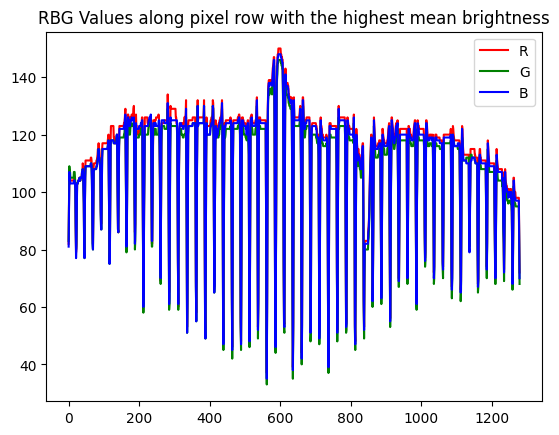

In [12]:
# line index was saved from before as the max brightness row

plt.plot(sample_img[line_index,:,0], label='R', color='red')
plt.plot(sample_img[line_index,:,1], label='G', color='green')
plt.plot(sample_img[line_index,:,2], label='B', color='blue')
plt.title('RBG Values along pixel row with the highest mean brightness')


plt.legend()
plt.show()

Given our knowledge of piano keys, we expect that all the local minima in this graph is the black space between the white piano keys. For our piano grid, we want to use this black space as a divisor.

#### Plotting just the average of the RGB values:

Text(0.5, 1.0, 'Average RGB value for each pixel along the row')

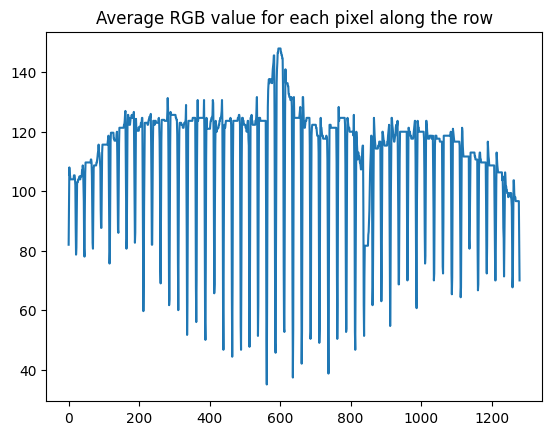

In [13]:
line_avg_colors = np.mean(sample_img[line_index, :, :], axis=1)
plt.plot(line_avg_colors, label='average color')
plt.title('Average RGB value for each pixel along the row')

**Next step:** find the local minima

## Difficulties with finding the minima 

Okay, so I did some experimentation outside of this notebook. It took some time to find a good way to find the peaks, I will summarize...

#### `order`/`distance` flag
At first, it was grabbing local minima that were up near the top of the graph, representing small changes in brightness but were not related to the black space between keys. The `order` flag will only consider local minima that have the lowest values in the nearest `order` neighbours. From my experiments, `30` is a good value to eliminate the bad minima. Since I switch to `find_peaks` (explained in the next paragraph), the flag is called `distance`.

#### missing values
I noticed not all the minima were being plotted. Zooming in on these minimas revealed that they were **flat minima**, which is more than 1 sample wide. As it turns out, `scipy`'s `argrelextrema` function ["requires a strict inequality on both sides to consider it a maximum"](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmax.html). As suggested by the scipy docs, `find_peaks` can be used as an alternative to find flat minima, we just need to invert the line to search for maximums instead.

### Finding minima 

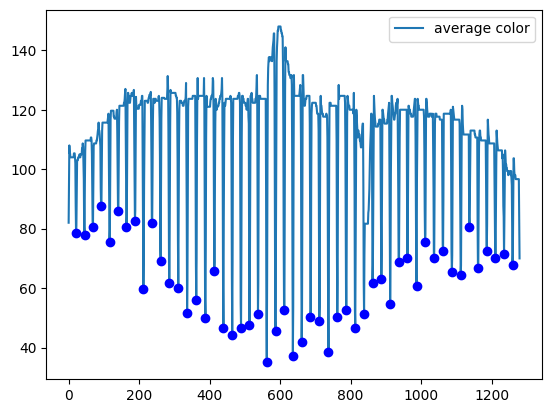

In [14]:
plt.plot(line_avg_colors, label='average color')

negated = [-i for i in line_avg_colors]

# Finding local minimas
minimas = find_peaks(negated, distance=20)[0]

for m in minimas:
    plt.plot(m, line_avg_colors[m], 'bo')

plt.legend()
plt.show()

### Plotting minima as veritcal lines on sample image

Number of white keys: 50/52


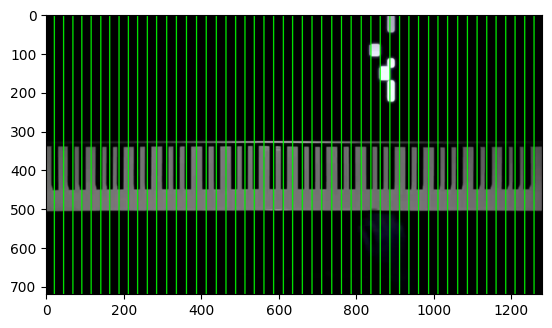

In [15]:
print(f'Number of white keys: {len(minimas)-1}/52')

plot_minima = copy.deepcopy(sample_img)

# Plot vertical line for each local minima
for m in minimas:
    cv2.line(plot_minima, (m, 0), (m, plot_minima.shape[0]), (0, 255, 0), 2)
    
plt.imshow(plot_minima)

#### Putting in a function:

In [16]:
def find_max_brightness_index(img):
    'Returns the row index with the max brightness'
    mean_brightness_per_row = [np.mean(img[i, :,:]) for i in range(img.shape[0])]
    line_index = mean_brightness_per_row.index(max(mean_brightness_per_row))
    return line_index

In [17]:
def separate_white_keys(img):
    'Returns list of x values to separate white keys with a veritcal line'
    max_brightness_index = find_max_brightness_index(img)
    
    line_avg_colors = np.mean(img[max_brightness_index, :, :], axis=1) # easiest to just average RBG values
    
    negated = [-i for i in line_avg_colors] # so that we can use find_peaks for flat minima

    # Finding local minimas
    minimas = find_peaks(negated, distance=20)[0]
    return minimas

143


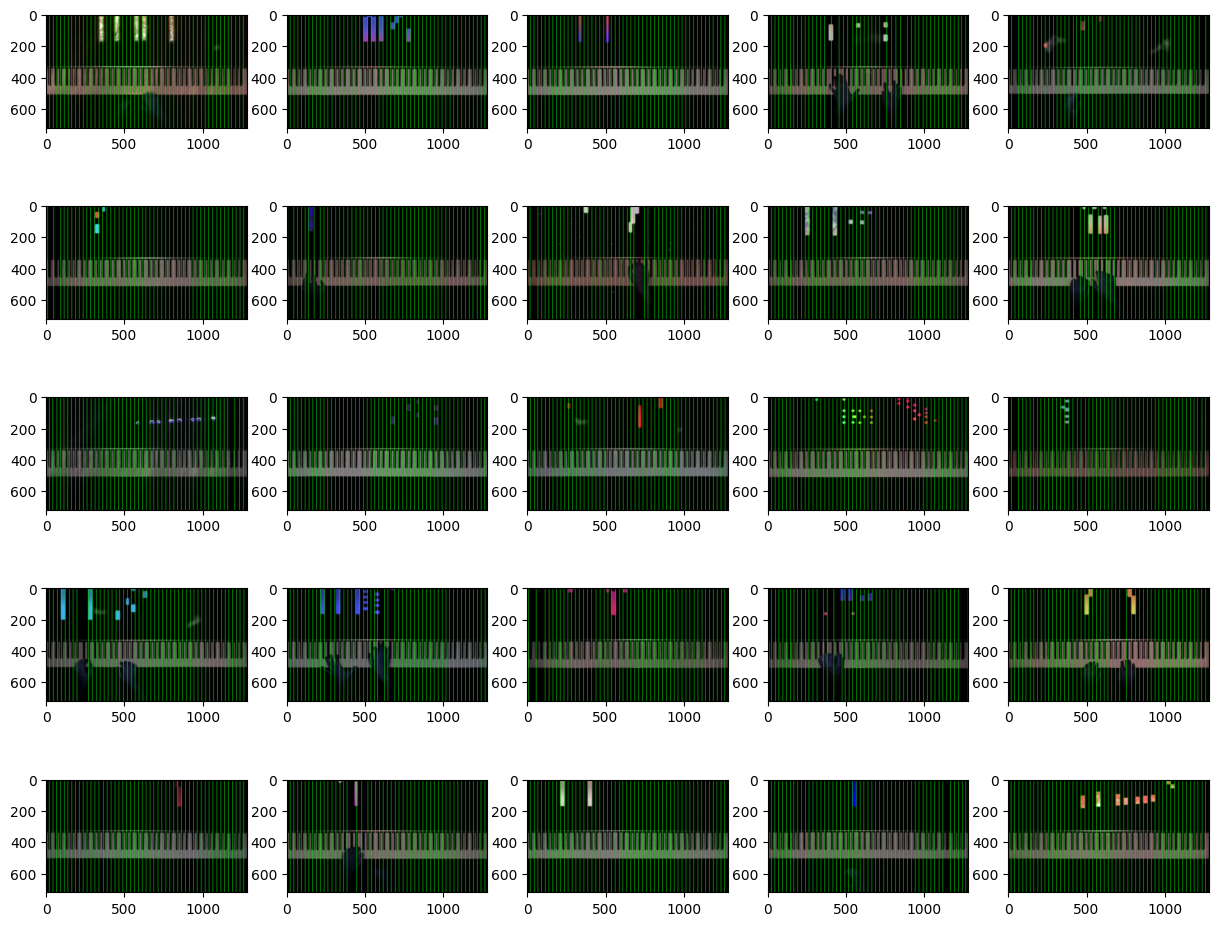

In [18]:
white_keys_opening_frames = []
print(len(opening_frames))

for i in copy.deepcopy(opening_frames):
    minima = separate_white_keys(i)
    
    # Plot vertical line for each local minima
    for m in minima:
        cv2.line(i, (m, 0), (m, i.shape[0]), (0, 255, 0), 2)
        
    white_keys_opening_frames.append(i)
    
plot_multiple(white_keys_opening_frames)

## Generalization
I've been thinking about this concept a lot for the remainder of piano grid task. I've been trying as much as possible to create a **generalizable solution** for this problem so that as/if we expand the dataset, it will be straightfoward to implement the piano grid detection on new videos. 

There are a few key differences between videos (either by the same channel or a new one) that will influence the techniques used for grid detection. They are:

#### (1) Brightness & Background
Depending on the recording method and "creative decisions" by the editor, the brightness of the keyboard, hands, and background could all be different. Large differences in this will definitely affect the methods used so far (finding the white keys using the max brightness).

#### (2) Number of visible keys
Depending on the piano size and view of the camera, there will be a different number of keys visible in each video.

#### (3) Straightness of frame
It's possible that the piano may not be perfectly level in the frame. This will also affect the results.

#### (4) Fish-eye and other perspective changes
Camera's aren't perfect, and neither are the people who are setting them up to record the piano videos. If possible, we want a solution that can accomodate for this.

# Exploring other solutions
It's worth exploring if there are pre-existing solutions that would work for the task. I started realizing this is a bigger task than I thought, so there is another notebook for this.

## Ideas for cropping the keyboard of Rousseau videos:

#### (1) Thresholing the low-brightness areas
* The black background has a much lower average brightness than the keyboard
* Therefore there should be a large gap where a threshold can be safely placed that works for all videos

#### (2) Using slopes from the brightness line
* If there if a huge change in brightness (big slope), it could be the start/end of the keyboard

#### Trying thresholding:

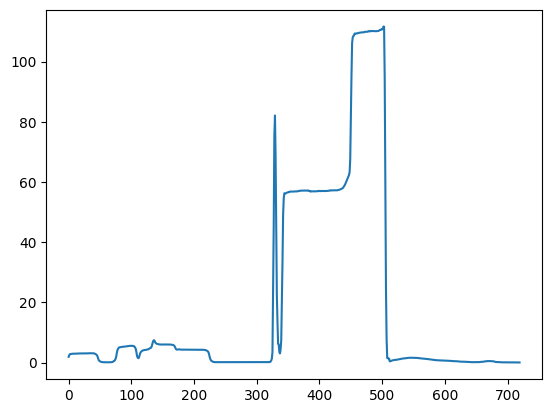

In [19]:
plt.plot(mean_brightness_per_row)

**In the above plot,** 
* `<20` can safely be assumed as background (not keyboard)
* `>80` is white keys
* `40-60` is black keys **other than the glare**

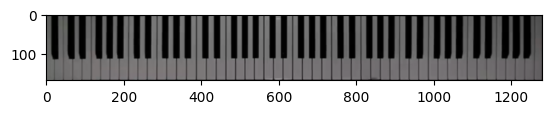

In [20]:
# cropped_img = copy.deepcopy(sample_img)
cropped_img = []

for row in sample_img:
    mean_brightness = row.mean()
    if mean_brightness > 40:
        cropped_img.append(row)
cropped_img = np.array(cropped_img)

plt.imshow(cropped_img)

Side note: [this page](https://www.analyticsvidhya.com/blog/2021/05/solving-sudoku-from-image-using-deep-learning-with-python-code/) (and similar attempts) use classic CV methods to detect a sudoku grid. These techniques can also be applied to our keyboard, so I will try to test them.

Another note: I'm cropping to only the keyboard here to demonstrate finding the keys, but when we actually apply this, we will want to keep the blackspace below to improve the hand detection model.

#### Black keys:

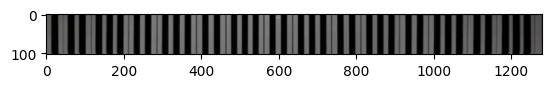

In [21]:
cropped_img = []

for row in sample_img:
    mean_brightness = row.mean()
    if 60 > mean_brightness > 40:
        cropped_img.append(row)
cropped_img = np.array(cropped_img)

plt.imshow(cropped_img)

#### Plotting a row of brightness for black keys:

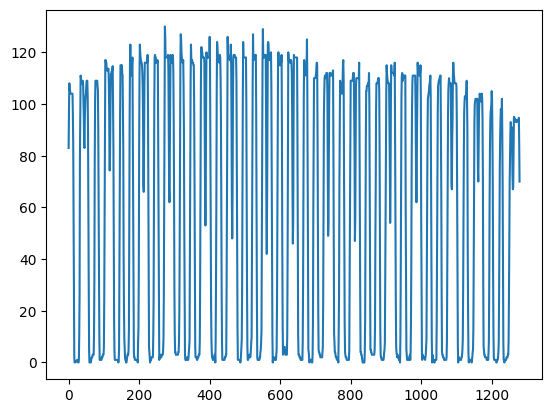

In [22]:
plt.plot(cropped_img[100].mean(axis=1))

Again, we could threshold this with a hard-coded value, maybe the easier solution for now...

#### Threshold of 20:

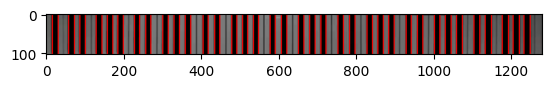

In [23]:
threshold = 20
black_key_lines = []
on_black_key = False

for index, value in enumerate(cropped_img[100].mean(axis=1)):
    if on_black_key:
        if value > threshold:
            black_key_lines.append(index)
            on_black_key = False  
    elif value < threshold:
        black_key_lines.append(index)
        on_black_key = True

for i in black_key_lines:
    cv2.line(cropped_img, (i, 0), (i, cropped_img.shape[0]), (255, 0, 0), 2)
    
plt.imshow(cropped_img)

## How to define the grid
The point of the "grid" is to map fingers to piano keys. We should have a function that, given the x and y coordinate of a finger, will return the **probability of that finger playing each note**. The returned list will therefore be length 88. The index will correspond to the MIDI note. If the full keyboard is not visible, we will have to have some way to deal with this. 

#### Given this info, we could map it as:

##### Keys as squares, store top-left corner, width, and height
This is a bit too verbose, since we know all black/white keys will have the same height and width. Plus, the y coordinate of the top-left corner will always be the same. Also, the white keys are not really squares since the black keys overlap them.

We can **avoid the tough shape of white keys** by:
* (1) Detecting if the finger coordinates are on the keyboard
* (2) Checking if it is on a black key
* (3) If not on a black key, it's on a white key

**The problem with this** is that it does not map probabilties as we dicussed. It would only find the one key that the finger is on. Therefore, my new idea is:

##### Keys as a single x-coordinate, representing the left side of the key
This seems to be how the `At Your Fingertips` paper implements it, at least how I understand it from `Section 3.5`. You can then calculate the width of key k with `w = X[k + 1] - X[k]`.

But this seems problematic to me since black and white keys overlap. It would work if we only had white keys, but that calculation wouldn't get the right width is `k` was white and `k+1` was black, OR vise versa!

I think I'm going to have to properly inspect their code to understand what they're implementing, and if it would work properly. That will be done in the lit-review notebook and I'll add the results here. 

For now, let's put all the pieces I've built together...

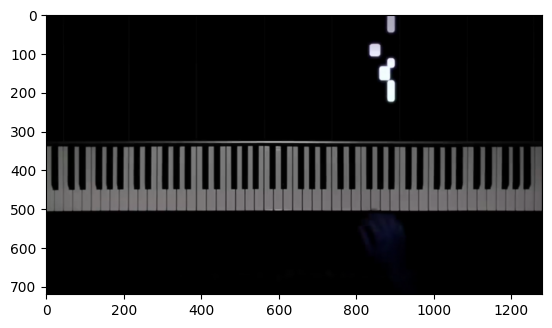

In [24]:
plt.imshow(sample_img)

### Defining Functions
This is all recycled code from above

In [25]:
# length_threshold is to avoid the glare in Rousseau videos
def find_vertical_section(img, upper_threshold, lower_threshold, length_threshold=50): 
    'Utility function for the vertical cropping functions, returns a cropped section given thresholds of brightness'
    cropped_img = []
    
    start_index = 0
    end_index = 0
    
    length = 0
    
    for index, row in enumerate(img):
        mean_brightness = row.mean()
        
        if upper_threshold > mean_brightness > lower_threshold:
            if length == 0:
                start_index = index
            length +=1
            
            cropped_img.append(row)
            
        else:
            if length > length_threshold: # found a valid section, quit the loop
                end_index = index
                break 
            else: # not long enough, reset streak
                cropped_img = []
                length = 0
                
    cropped_img = np.array(cropped_img)
    
    return cropped_img, start_index, end_index

In [26]:
def crop_keyboard(img, lower_threshold=40):
    'Performs a vertical crop of an input image to detect keyboard space'
    upper_threshold = 1000 # just an arbitrarily high number
    
    res = find_vertical_section(img, upper_threshold, lower_threshold)
    
    if res == []:
        raise('Error: crop_keyboard did not find any matching image section with the specified threshold')
    else:
        return res

In [27]:
def crop_black_keys(img, upper_threshold=60, lower_threshold=40):
    'Takes uncropped video frame and crops vertically to the black key height'
    
    res = find_vertical_section(img, upper_threshold, lower_threshold)
    
    if res == []:
        raise('Error: crop_black_keys did not find any matching image section with the specified thresholds')
    else:
        return res

In [28]:
def separate_black_keys(img, threshold=20):
    'Returns list of x values to separate black keys with a vertical line'
    cropped_img, _, _ = crop_black_keys(img)
    
    black_key_lines = []
    on_black_key = False
    
    cropped_img = cropped_img.mean(axis=2) # average RBG values for simplicity

    for index, value in enumerate(cropped_img[int(len(cropped_img)/2)]): # arbitrary index in the middle
        if on_black_key:
            if value > threshold:
                black_key_lines.append(index)
                on_black_key = False  
        elif value < threshold:
            black_key_lines.append(index)
            on_black_key = True
    return black_key_lines

In [29]:
def plot_lines(img, lines, rgb_tuple):
    'Plots list of lines ON TOP OF THE input image'
    
    for i in lines:
        cv2.line(img, (i, 0), (i, img.shape[0]), rgb_tuple, 2)

#### Demo

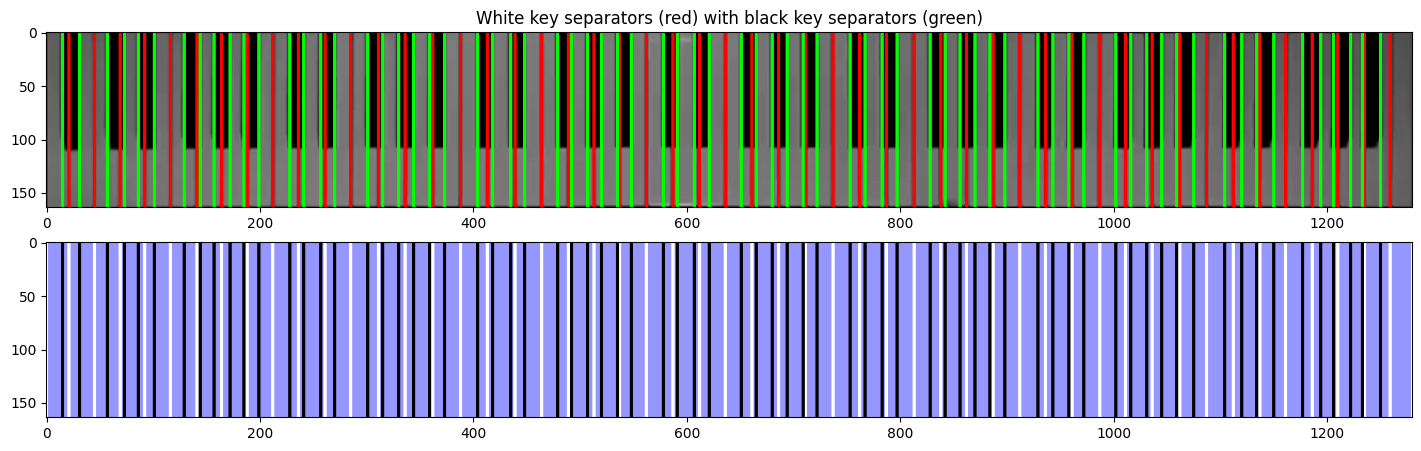

In [30]:
white_key_lines = separate_white_keys(sample_img)

# Hardcoding lines at the start and end
white_key_lines = np.insert(white_key_lines, 0, 0)
white_key_lines = np.append(white_key_lines, sample_img.shape[1])

black_key_lines = separate_black_keys(sample_img)

keyboard_img, _, _ = crop_keyboard(sample_img)

plot_lines(keyboard_img, white_key_lines, (255, 0, 0))
plot_lines(keyboard_img, black_key_lines, (0, 255, 0))

# Second plot without image
just_lines = np.full(keyboard_img.shape, (150, 150, 255), dtype=np.uint8)
plot_lines(just_lines, white_key_lines, (255, 255, 255))
plot_lines(just_lines, black_key_lines, (1, 1, 1))


fig, ax = plt.subplots(2, 1, figsize=(20,5))
ax[0].imshow(keyboard_img)
ax[0].set(title='White key separators (red) with black key separators (green)')

ax[1].imshow(just_lines)

plt.show()

### Assumptions to help with shape drawing
* There is a consistent pattern for the order between white and black keys
* There will always be a black separator between two white separators (but not the other way around)

Labelling lines as white or black, starting from the left side of A natural:
```
W  B   W  /B   [  W  B   W  /B  B   W  /B  W   B   W  /B  B   W  /B  B   W  /B  ]*7?   W  W
A  A#  B       [  C  C#  D      D#  E      F   F#  G      G#  A      A#  B      ]*7?   C  (End of keyboard)

^-----------^ this bottom part of the keyboard is a bit irregular since usually there is a black key below the A that would change the order a bit. This is the same for the top of the keyboard, which I notated.
```

In [31]:
# modelled from above
is_black = [ 0, 1, 0, 1] + [0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1]*7 + [0, 0 ]

In the future, if we collect data that does not have the full keyboard, we can do some sort of pattern matching with the middle data to find what the keys should be! But no use over-complicating it right now since Rousseau is consistent.

# Shapes
We want to create bounding boxes for the keys given the line separators we've generated and the assumption line ordering described above.

## Black keys
Black keys are easiest. We can simply generate a rectangle, width will be from `black_key_lines[i]` to `black_key_lines[i+1]` (this is pseudocode, will find the line values using a combined list and `is_black` as a lookup table) and height will be from the top of the keyboard `KT` to the black key bottom `BKB`. 

## White keys
White keys are trickier. They are not rectangles since the corners at cut off by black keys, and assuming them as rectangles would be an bad oversimplification. For this reason, we will generate polygons using a list of coordinates. All white keys fall under three shape types:
* (1) White key shape 1 defines keys `C` and `F`, where the top-right corner is cut off.
* (2) This covers keys `D`, `G`, and `A`, where both top corners are cut off.
* (3) Keys `E` and `B` are in this type, they are flipped from type 1, and are missing the top-left corner.

## Defining some variables
To understand the coordinates that we will use, some nomenclature will be used.

#### Height variables
The top and bottom of the keyboard will be defined as `KT` and `KB`, resectively. The top of the black keys is assumed to be equal to `KT`. The bottom of the black keys will be defined as `BKB`.

#### Width variables
The full width of a key is from one line to the next line of the same color (for black, we need to make sure that we start with the right line). Depending on the shape type of the white key, 1-2 of the black key separators between these white lines are needed to create the cut-out shape. We will use `x1` and `x2` as the full width of keys (not considering the cut-out for white keys).

In [32]:
# Some variables to be used later to loop through all keys in a nice way
white_key_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

white_key_shapes = [
    ['C', 'F'],
    ['D', 'G', 'A'],
    ['B', 'E'],
]

def get_key_shape(key_name):
    for key_type, L in enumerate(white_key_shapes):
        if key_name in L:
            return key_type + 1 # We'll use 1-indexing, since it was defined as such above
    print('Error: key_name not found in list of shapes')

In [33]:
def combine_white_and_black_lines(white_lines, black_lines):
    'Returns one list, ordered low-to-high'
    combined = np.concatenate((white_lines, black_lines))
    
    sorted_list = np.sort(combined)
    
    if len(set(combined)) < len(combined):
        print('There\'s a problem, separators for the white and black keys have at least one duplicate...')
        
    return sorted_list

In [34]:
def get_height_info(img):
    'Returns the y coordinate for the keyboard top (KT), black-key bottom (BKB), and keyboard bottom (KB)'
    _, KT, KB = crop_keyboard(img)
    _, _, BKB = crop_black_keys(img)
    return KT, BKB, KB

In [35]:
def draw_black_key(img, full_line_list, curr_index, KT, BKB, KB):
    'Given an image and the current position in a list of lines, draw the shape of the current black key'
    
    assert is_black[curr_index] == 1
    if curr_index + 2 >= len(full_line_list):
        print('End of lines reached on a black key, not drawing')
        return
    
    x1 = full_line_list[curr_index]
    
    # We know that if this black line is the START of a black key, the end line is always index+2
    x2 = full_line_list[curr_index+2]
    
    # cv2 needs the top-left and bottom-right coordinates
    top_left = (x1, KT)
    bottom_right = (x2, BKB)
    
    cv2.rectangle(img, top_left, bottom_right, (255, 100, 100), 4) # fill
#     cv2.rectangle(img, top_left, bottom_right, (0, 0, 0), 4) # outline

In [36]:
def draw_polygon(img, list_of_coordinates, rgb_tuple=(0,255,255), fill=False):
    'Helper function for drawing polygons for white keys'
    
    # drawing polygons is weird: https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html
    pts = np.array(list_of_coordinates, np.int32)
    pts = pts.reshape((-1,1,2))
    
    if fill:
        cv2.fillPoly(img,[pts], rgb_tuple)
    else:
        cv2.polylines(img,[pts],True, rgb_tuple)

In [37]:
def draw_white_key_polygon(img, full_line_list, curr_index, white_key_name, KT, BKB, KB):
    'Draws a polygon given an image, the current position in a list of lines, and the name of the white key'
    assert is_black[curr_index] == 0
    x1 = full_line_list[curr_index]
    
    x2 = 0
    
    if curr_index + 2 >= len(full_line_list):
        print('Done keyboard')
        # Hardcoding the final C-key
        top_left = [full_line_list[curr_index], KT]
        top_right = [full_line_list[curr_index+1], KT]
        bottom_right = [full_line_list[curr_index+1], KB]
        bottom_left = [full_line_list[curr_index], KB]
        draw_polygon(img, [top_left, top_right, bottom_right, bottom_left])
        return
    
#     print(f'is black len: {len(is_black)}, full line list len: {len(full_line_list)}')
    
    for i in range(curr_index+1, len(full_line_list)-1):
        if is_black[i] == 0:
            x2 = full_line_list[i]
            break
    if x2 == 0:
        print('Something went wrong, next white note wasn\'t found')
    
    key_shape = get_key_shape(white_key_name)
    
    # Keys C and F
    if key_shape == 1:
        # We know for this shape that the next line in the list is the black key cutting it off
        next_black_key = full_line_list[curr_index+1]
        
        # defined in clockwise order
        bottom_right = [x2, KB]
        bottom_left = [x1, KB]
        top_left = [x1, KT]
        
        cutout_pt_1 = [next_black_key, KT]
        cutout_pt_2 = [next_black_key, BKB]
        cutout_pt_3 = [x2, BKB]
        
        draw_polygon(img, [bottom_right, bottom_left, top_left, cutout_pt_1, cutout_pt_2, cutout_pt_3])
        
    # Keys D, G, and A
    elif key_shape == 2:
        # For this shape, there are two black lines between the white lines
        black_key_1 = full_line_list[curr_index+1]
        black_key_2 = full_line_list[curr_index+2]
        
        # clockwise order
        bottom_right = [x2, KB]
        bottom_left = [x1, KB]
        
        left_cutout_1 = [x1, BKB]
        left_cutout_2 = [black_key_1, BKB]
        left_cutout_3 = [black_key_1, KT]
        
        right_cutout_1 = [black_key_2, KT]
        right_cutout_2 = [black_key_2, BKB]
        right_cutout_3 = [x2, BKB]
        
        draw_polygon(img, [bottom_right, bottom_left, 
                        left_cutout_1, left_cutout_2, left_cutout_3, 
                        right_cutout_1, right_cutout_2, right_cutout_3])
        
    # Keys E and B
    elif key_shape == 3:
        # We know for this shape that the next line in the list is the black key cutting it off
        next_black_key = full_line_list[curr_index+1]
        
        # clockwise order
        top_right = [x2, KT]
        bottom_right = [x2, KB]
        bottom_left = [x1, KB]
        
        cutout_pt_1 = [x1, BKB]
        cutout_pt_2 = [next_black_key, BKB]
        cutout_pt_3 = [next_black_key, KT]
        
        draw_polygon(img, [top_right, bottom_right, bottom_left, cutout_pt_1, cutout_pt_2, cutout_pt_3])
    
    else:
        print('Something went wrong, bad key shape provided')

#### Main function for drawing key shapes

In [38]:
# this still assumes a full keyboard, the beggining and end would need to be fixed in the future
def draw_key_shapes(img, DEBUG=False, with_global_vars=False):
    'Draws the entire keyboard'
    output_img = copy.deepcopy(img)
    
    white_key_lines = []
    black_key_lines = []
    full_line_list = []
    KT = 0
    BKB = 0
    KB = 0
    
    if with_global_vars:
        white_key_lines = separate_white_keys(sample_img)
        black_key_lines = separate_black_keys(sample_img)
        full_line_list = combine_white_and_black_lines(white_key_lines, black_key_lines)
        
        # Hardcoding lines at the start and end
        if len(full_line_list) == 123: # needs two more
            full_line_list = np.insert(full_line_list, 0, 0)
            full_line_list = np.append(full_line_list, sample_img.shape[1])
    
        
        KT, BKB, KB = get_height_info(sample_img)
    else:
        white_key_lines = separate_white_keys(output_img)
        black_key_lines = separate_black_keys(output_img)
        full_line_list = combine_white_and_black_lines(white_key_lines, black_key_lines)
        
        # Hardcoding lines at the start and end
        if len(full_line_list) == 123: # needs two more
            full_line_list = np.insert(full_line_list, 0, 0)
            full_line_list = np.append(full_line_list, sample_img.shape[1])

        KT, BKB, KB = get_height_info(output_img)
        
    print(f'Length of line list: {len(full_line_list)}')

    # assumes we start on A0
    index = 0
    white_key_number = 0
    key_letter = white_key_names[white_key_number % len(white_key_names)]
    
    last_key = full_line_list[index]
    # I give it the letter F since A0 is a different shape than all other As, and it closer to F
    draw_white_key_polygon(output_img, full_line_list, index, 'F', KT, BKB, KB)
    index += 1
    white_key_number += 1
    
    while index < len(full_line_list)-1:
#         if index == 5:
#             break
    
        # White key
        if is_black[index] == 0:
            key_letter = white_key_names[white_key_number % len(white_key_names)]
            
            
            draw_white_key_polygon(output_img, full_line_list, index, key_letter, KT, BKB, KB)
            
            key_shape = get_key_shape(key_letter)
            
            if DEBUG:
                print(f'White key, index {index}, letter {key_letter}, shape {key_shape}')
            
            if key_shape == 2 or key_shape == 3:
                index += 2 # skip the 1 closing black line
            else:
                index += 1
            
            white_key_number += 1
            
        # Black key
        else:
            if DEBUG:
                print(f'Black key, index {index}, letter {key_letter}#')
            draw_black_key(output_img, full_line_list, index, KT, BKB, KB)
            index += 1 
    
    return output_img

Length of line list: 125
Done keyboard


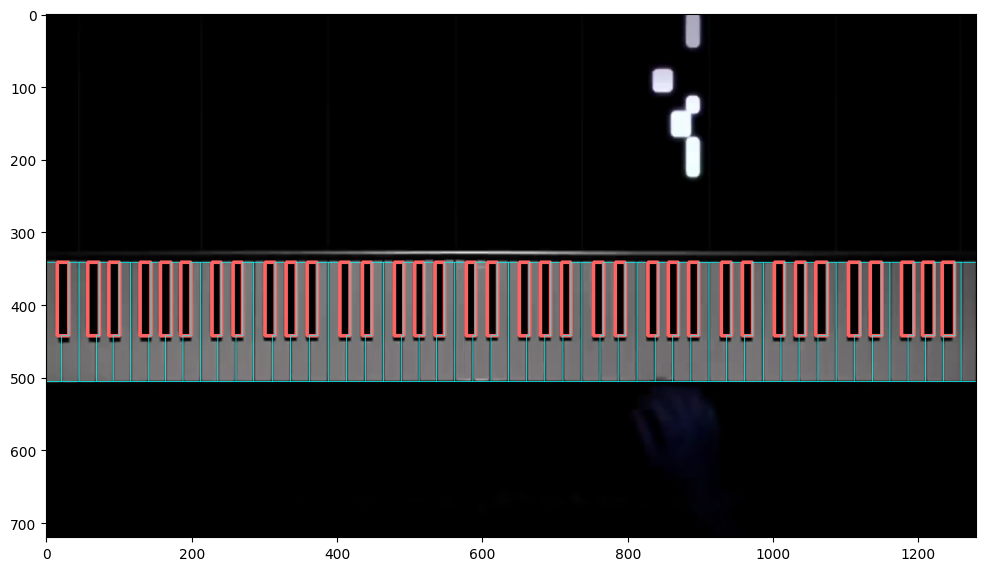

In [39]:
output = draw_key_shapes(sample_img, DEBUG=False)

short = output[:,:500,:]

fig, ax = plt.subplots(figsize=(12,10))
ax.imshow(output)
plt.show()

OK! We've successfully drawn the piano keys given an input Rousseau frame!

Let's plot a bunch of intros to see if it's consistent...

There's a problem, separators for the white and black keys have at least one duplicate...
Length of line list: 125
Done keyboard
There's a problem, separators for the white and black keys have at least one duplicate...
Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard
There's a problem, separators for the white and black keys have at least one duplicate...
Length of line list: 117
Done keyboard
There's a problem, separators for the white and black keys have at least one duplicate...
Length of line list: 125
Done keyboard
Length of line list: 122
Something went wrong, next white note wasn't found
End of lines reached on a black key, not drawing


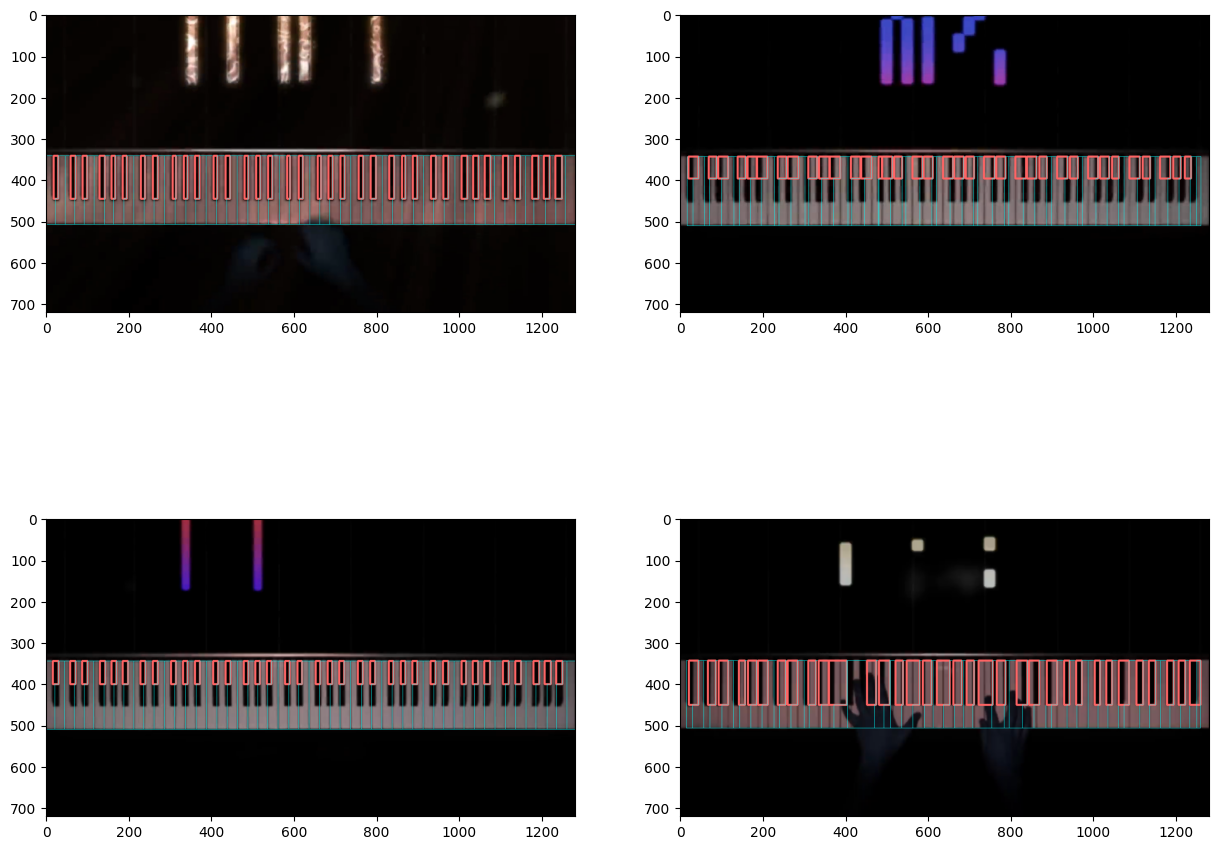

In [40]:
# opening_frames = grab_opening_frames()

outputs = []

for i in opening_frames[:6]:
    res = draw_key_shapes(i)
    outputs.append(res)
    
plot_multiple(outputs, 2, 2)

OK, that definitely didn't work as expected....

Two things to check:
* Would the grid on my very first working test apply to all opening frames?
* Check why the others are failing

#### With new global variable flag:

Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard
Length of line list: 125
Done keyboard


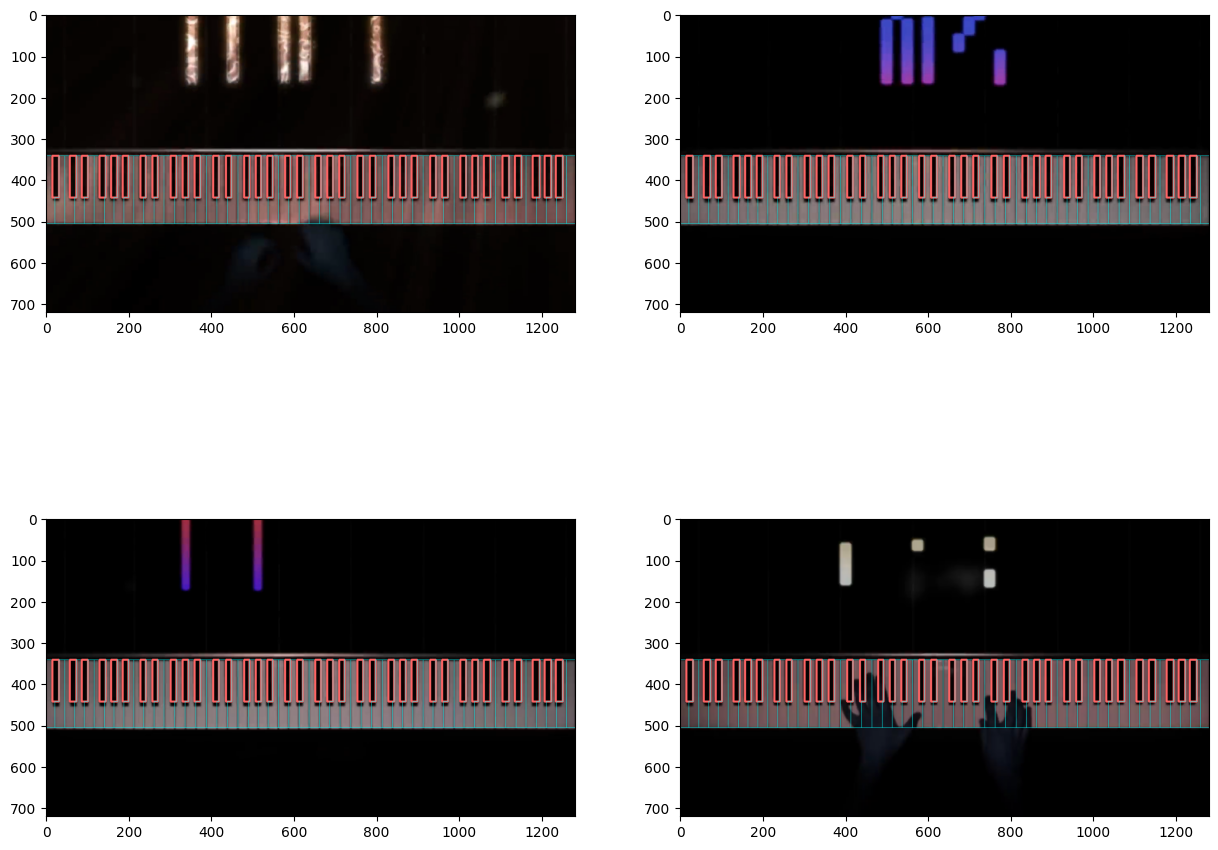

In [41]:
# opening_frames = grab_opening_frames()

outputs = []

for i in opening_frames[:6]:
    res = draw_key_shapes(i, with_global_vars=True)
    outputs.append(res)
    
plot_multiple(outputs, 2, 2)

Length of line list: 125
Done keyboard


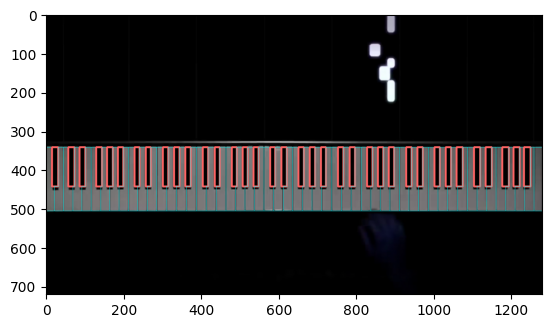

In [42]:
res = draw_key_shapes(copy.deepcopy(sample_img), with_global_vars=True)
plt.imshow(res)

Done keyboard
Finished creating grid.


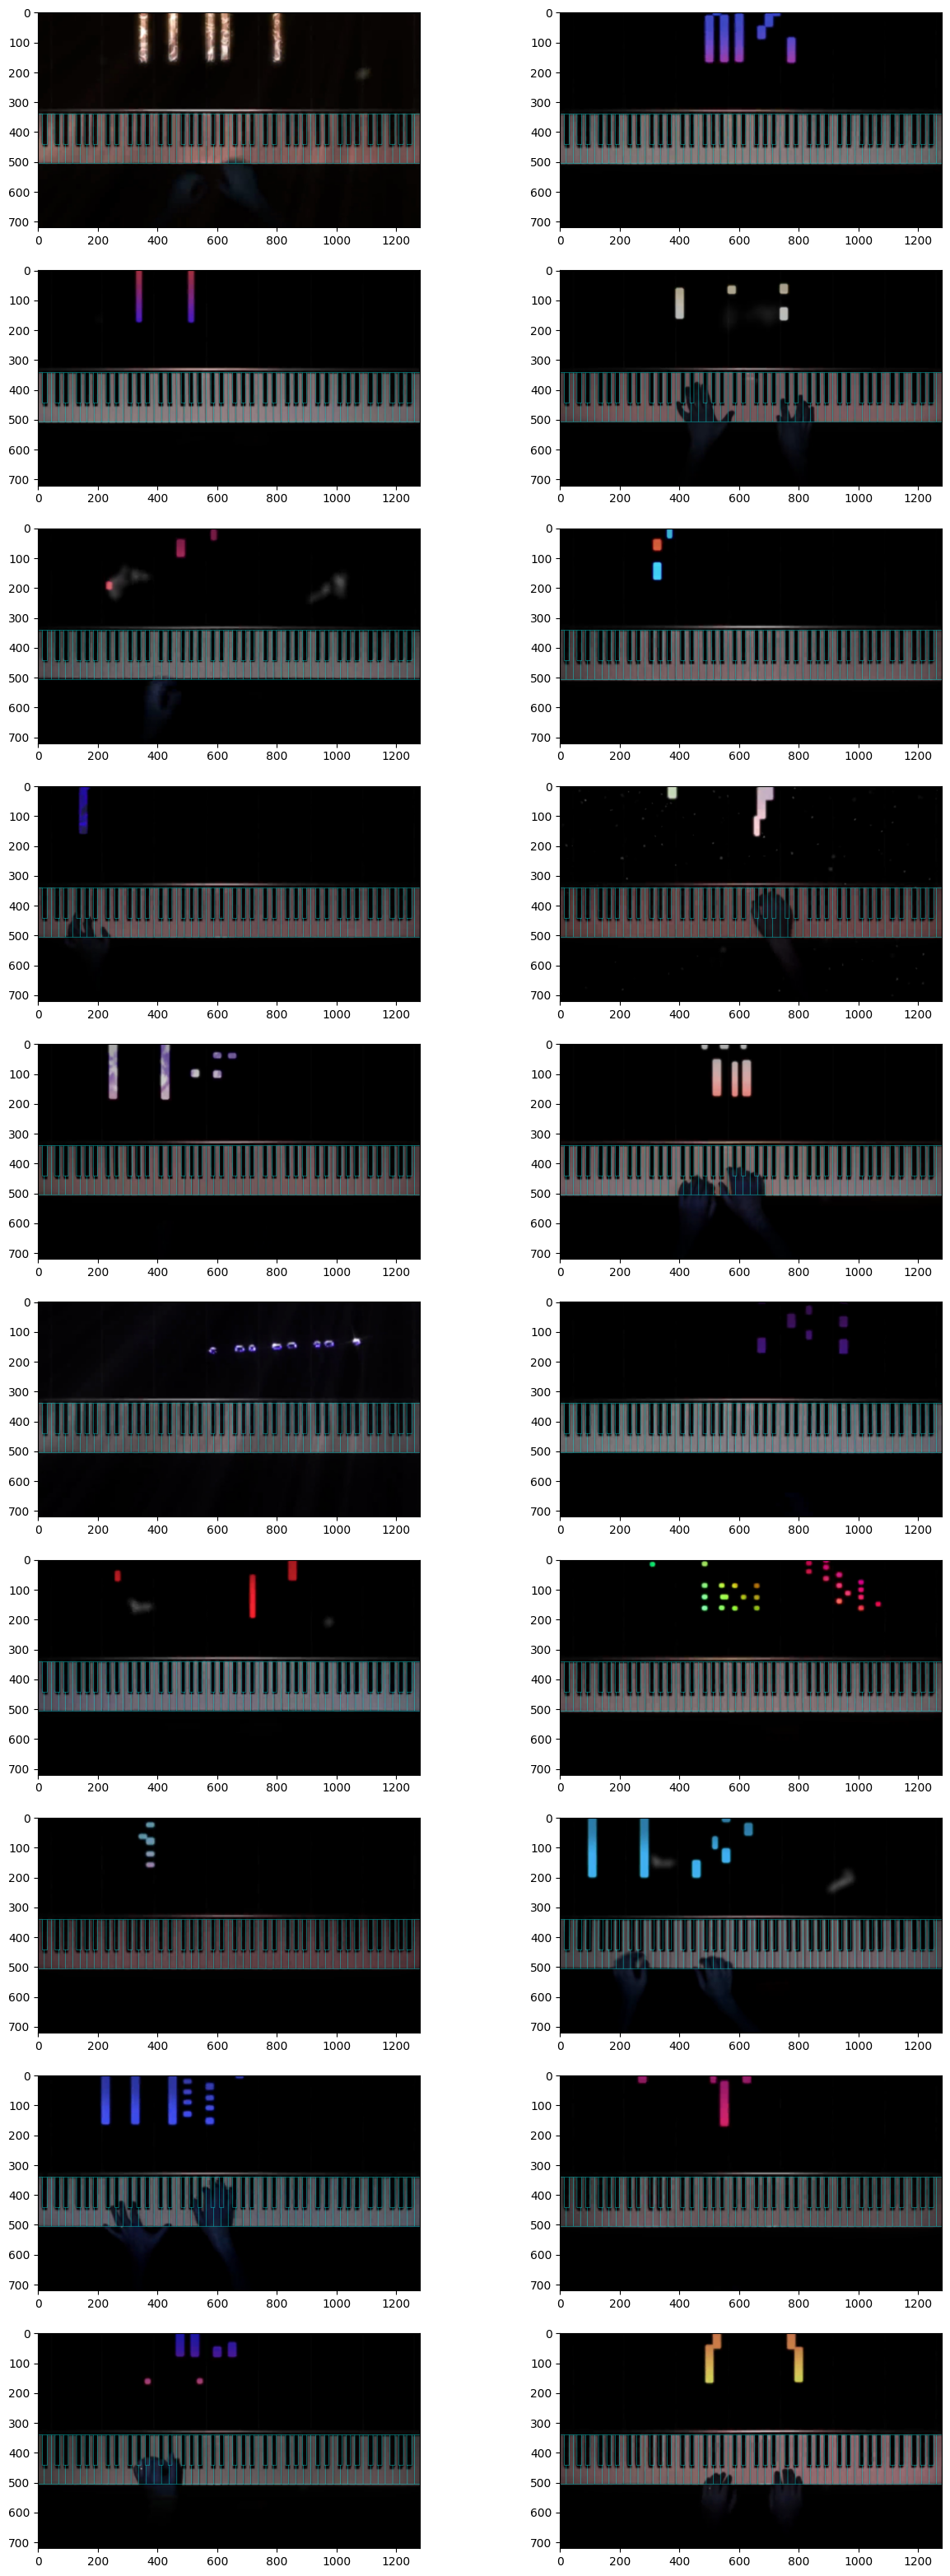

In [58]:
# Testing the class implementation 
from rousseau_grid import PianoGrid
import matplotlib.pyplot as plt

outputs = []
rows = 10
cols = 2

grid = PianoGrid()

for i in opening_frames[:rows*cols]:
    res = grid.draw_grid(copy.deepcopy(i), use_global_polygons=True)
    outputs.append(res)
    
plot_multiple(outputs, rows, cols, size=(15, 40))